###  ML-Modell

Dieser Prozess kann wie folgt zusammengefasst werden:

1. Metrik wählen 
2. Systematisches Testen einer Reihe verschiedener Algorithmen in ihrem Datensatz.(Kreuzvalidierungsverfahren'StratifiedKFold')
3. Hyperparameter-Tuning (Randomsearch, Bayessche_Optimierung )
4. Select Features-Filter 
5. Ergbnisse präsentieren (Precision-Recall-Metrik und F_1)


Dieses Problem ist eine typische Klassifikationsaufgabe, deswegen habe ich mich für vier Klassifikation Modellen ausgesucht.

1. Logistic Regression
2. Support Vector Machine (SVM)
3. KNeighborsClassifier
4. RandomForestClassifier

Die Bankabwanderung sollte unter 25 % liegen, daher ein Modell, das besagt „Niemand wird abwandern“, muss zu 75 % genau sein. Ich konzentriere mich auf alle Abwanderungen, die das Modell korrekt identifiziert und der Prozentsatz der identifizierten Abwanderung, der tatsächlich zur Abwanderung führt. 


In diesem Fall handelt sich um eine unausgewogene Klassifizierung, deswegen habe ich mich für die Metriken Präzision, Recall und F_1 entschieden. 

Präzision = TruePositives / (TruePositives + FalsePositives)
Recall = TruePositives / (TruePositives + FalseNegatives)

Diese Metriken werten FalsePositives aus, die zu unnötigen und kostspieligen Bemühungen zur Vermeidung von Abwanderungen führen, und FalseNegatives, die dazu führen, dass Kunden aus dem Unternehmen abwandern, ohne identifiziert zu werden.

Die Leistung eines Modells kann durch einen einzigen Wert zusammengefasst werden, der sowohl die Präzision als auch den Recall mittelt, der als F-Maß bezeichnet wird. Die Maximierung des F-Measure maximiert sowohl die Präzision als auch den Recall 
gleichzeitig.


Der **F1-Score** ist eine Metrik, die die Genauigkeit zu erfassen versucht, wenn Klassen unausgeglichen sind, indem sie sich auf die Präzision positiver Vorhersagen und tatsächlich positiver Datensatzeinträge konzentriert. Sie gibt an, wie genau das Modell relevante Ergebnisse erfasst. Die Metrik versucht, Recall und Präzision auszugleichen, um im Idealfall eine mittlere Position zwischen beiden zu finden. Je unausgeglichener ein Datensatz ist, desto geringer ist voraussichtlich der F1-Score, selbst bei gleicher Gesamtgenauigkeit.

Wenn der F1-Wert hoch ist, sind auch alle anderen Bewertungsmetriken hoch. Wenn der Wert niedrig ist, bedeutet das, dass sie eine weitere Analyse durchführen müssen. Wenn aber der Score sehr hoch ist oder der Holdout-Score wesentlich niedriger als der Kreuzvalidierungs-Score ist, könnte dies ein Anzeichen für Datenlecks sein.

F-Maß = (2 * Präzision * Recall) / (Präzision + Recall)

StratifiedKFold..?


#### Das beste Baseline-Modell finden
Die Idee ist den besten Algorithmus zu finden, der am besten auf als Basismodell funktioniert, das heißt ohne optimieren, und diesen auszuwählen, um ihn durch Hyperparameter-Tuning zu verbessern.

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from skopt import gp_minimize,dummy_minimize
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


SEED = 42
np.random.seed(SEED)

In [2]:
# pip install scikit-optimize

In [110]:
import skopt
print('skopt %s' % skopt.__version__)

skopt 0.9.0


In [3]:
df = pd.read_parquet('churn_model_clear.parquet')

In [4]:
df.shape

(9995, 14)

In [5]:
df.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,France,Spain,Germany
0,0.5,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0,1.0,0.0,1.0,0.0,0.0
1,0.5,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0,1.0,0.0,0.0,1.0,0.0
2,0.5,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0,1.0,0.0,1.0,0.0,0.0
3,0.5,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0,1.0,0.0,0.0,1.0,0.0
5,0.5,0.351351,0.8,0.453394,0.333333,1.0,0.0,0.748797,1.0,0.0,1.0,0.0,1.0,0.0
6,1.0,0.432432,0.7,0.000000,0.333333,1.0,1.0,0.050261,0.0,0.0,1.0,1.0,0.0,0.0
7,0.0,0.148649,0.4,0.458540,1.000000,1.0,0.0,0.596733,1.0,1.0,0.0,0.0,0.0,1.0
8,0.5,0.351351,0.4,0.566170,0.333333,0.0,1.0,0.374680,0.0,0.0,1.0,1.0,0.0,0.0
9,0.5,0.121622,0.2,0.536488,0.000000,1.0,1.0,0.358605,0.0,0.0,1.0,1.0,0.0,0.0


In [6]:
variable = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary','Female', 'Male',
       'France', 'Spain', 'Germany']

In [7]:
X = df[variable]
y = df['Exited']

In [8]:
X_train, X_valid , y_train, y_valid = train_test_split( X, y, test_size=0.33, random_state=SEED)

Mit den Methoden **GetBaseModel** und **ModelEvaluation** werden verschiedene Modelle verglichen.
StratifiedKFold ?cross_val_score?

In der Methode **ModelEvaluation** wird die Leistung einzelne Modellen durch die Technik Cross-Validation validiert.
Diese Technik besteht aus der Trennung der Daten in verschiedenen K-Fold (Falten). Die Teile werden für Training und Test verwendet. Die Daten für das Training wird immer anders sein als für den Test.

* Wenn die Daten sehr ähnliche Sätze sind, wird die tatsächliche Leistung von Modell maskiert
* Durch Training und Testen mit allen aus den verfügbaren Daten wird das Modell zuverlässiger
* Aussagekräftige Modellperformance auf Datensätzen mit Balance-Problemen 
* Identifizierung von Overfitting
* Testen der Robustheit des Modell
* Kreuzvalidierung löst das Varianzproblem in Daten.
<br>.
!['hallo'](bild/cross.png)
<br>.
   
   
   










Das Modell mit dem besten Scoring wird dann als Baseline benutz. Das beste Modell war der RandomForestClassifier mit einem Scoring(f1_weighted) von **0.843742** und eine Varianz **0.013131**.
Bei der Methode **ModelEvaluation** werden die Daten mit einem Stratified Kreuzvalidierungsverfahren trainiert. Das ist wichtig, weil die Daten unbalanciert sind.

In [84]:
def GetBaseModels():
    baseModels = []
    baseModels.append(('KNeighborsClassifier'  , KNeighborsClassifier()))
    baseModels.append(('RandomForestClassifier'   , RandomForestClassifier()))
    baseModels.append(('SVC' , SVC(kernel='linear',random_state=SEED)))
    baseModels.append(('KNeighborsClassifier',  KNeighborsClassifier()))
    
       
    return baseModels 

In [87]:
def ModelEvaluation(X_train, y_train,models):
    # define number of folds and evaluation metric
    num_folds = 10
    scoring = "f1_weighted" #This is suitable for imbalanced classes

    results = []
    names = []
    for name, model in models:
       # kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED, shuffle = True)
        kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=10, random_state=SEED)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs = -1)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [88]:
models = GetBaseModels()
ModelEvaluation(X_train, y_train, models)

KNeighborsClassifier: 0.775486 (0.015307)
RandomForestClassifier: 0.844653 (0.014260)
SVC: 0.706481 (0.001513)
KNeighborsClassifier: 0.775486 (0.015307)


(['KNeighborsClassifier',
  'RandomForestClassifier',
  'SVC',
  'KNeighborsClassifier'],
 [array([0.77879805, 0.77879805, 0.77687772, 0.78012965, 0.78202312,
         0.79691971, 0.77556376, 0.76379435, 0.75431839, 0.76615847,
         0.76855897, 0.79036298, 0.76314388, 0.7486344 , 0.77102545,
         0.81251059, 0.76234205, 0.79480361, 0.75253924, 0.81030979,
         0.74131805, 0.76545588, 0.76930592, 0.76991329, 0.78636213,
         0.79993778, 0.77176   , 0.75801715, 0.78209018, 0.79371421,
         0.76891685, 0.76545588, 0.80000957, 0.76176846, 0.79036298,
         0.76748778, 0.77337417, 0.78692762, 0.75915231, 0.7607827 ,
         0.76916348, 0.7962513 , 0.78232868, 0.77476706, 0.77493439,
         0.79679159, 0.76980392, 0.78131373, 0.75431839, 0.7620509 ,
         0.76730704, 0.78646747, 0.76385838, 0.78639437, 0.75349132,
         0.78907441, 0.79696013, 0.75751471, 0.78782465, 0.77067302,
         0.76558039, 0.76558039, 0.77476706, 0.77664723, 0.77476706,
         0.76

Nachdem die Baseline festgestellt wurde, werden die Hyperparameter gesucht. Ich habe zwei Techniken RandomSearch und 
Bayes'sche Optimierung angewandet. 

1. Die **RandomizedSearchCV** ist ein Ansatz zur Parameterabstimmung, bei dem Algorithmusparameter aus einer zufälligen 
Verteilung für eine feste Anzahl von Iterationen abgetastet werden. Für jede gewählte Kombination 
von Parametern wird ein Modell konstruiert und bewertet. Sie können mit der RandomizedSearchCV 
eine zufällige Suche nach Algorithmusparametern durchführen.


2. Die **Bayes'sche Optimierung** bietet eine prinzipielle Technik, die auf dem Bayes-Theorem basiert, um eine Suche nach einem globalen Optimierungsproblem zu steuern, das effizient und effektiv ist. Es funktioniert durch den Aufbau eines probabilistischen Modells der Zielfunktion, das als Ersatzfunktion bezeichnet wird, das dann effizient mit einer Erfassungsfunktion durchsucht wird, bevor Kandidatenstichproben zur Bewertung anhand der realen Zielfunktion ausgewählt werden.

Um die beiden Techniken zu implentiren werde ich die Scikit-Optimize-Bibliothek benutzen. Die Scikit-Optimize-Bibliothek ist eine Open-Source-Python-Bibliothek, die eine Implementierung der Bayes'schen Optimierung  und RandomSearch bereitstellt, mit der die Hyperparameter von Machine Learning-Modellen aus der scikit-Learn Python-Bibliothek optimiert werden können.

Zuerst habe ich  einen Suchraum definiert. In diesem Fall sind dies die Hyperparameter des Modells, das wir optimieren möchten, und der Umfang oder Bereich jedes Hyperparameters.

Ich habe dann eine Funktion definiert, die vom Suchvorgang aufgerufen wird. Dies ist eine Funktion, die später von der Optimierungsprozedur erwartet wird und ein Modell und einen Satz spezifischer Hyperparameter für das Modell verwendet, es auswertet und eine Bewertung für den Satz von Hyperparametern zurückgibt.

Als nächstes wurde die Suche ausgeführt, indem  die Funktion **gp_minimize()** und **dummy_minimize()** aufrufen und den Namen der aufzurufenden Funktion übergeben, um jedes Modell und den zu optimierenden Suchraum auszuwerten.



In [431]:
def treinar_modelo(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    min_samples_leaf = params[3]
    bootstrap = params[4]
    
    print(params, '\n')
    
    mdl = RandomForestClassifier(n_estimators= n_estimators, max_features=max_features,  max_depth= max_depth,
                        min_samples_leaf=min_samples_leaf,  bootstrap=bootstrap, random_state=SEED,  class_weight='balanced')
    mdl.fit(X_train, y_train)

    
    p = mdl.predict_proba(X_valid)[:,1]
    result = -roc_auc_score(y_valid, p)
   
    return  -roc_auc_score(y_valid, p)

space = [[int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)], # Number of features to consider at every split
         ('auto', 'sqrt'), # num_leaves
         [int(x) for x in np.linspace(10, 120, num = 12)], # maximum number of levels allowed in each decision tree), 
         (1, 2), # minimum sample number that can be stored in a leaf node
         (True, False)] # method used to sample data points


In [432]:
randomsearch = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=10)

Iteration No: 1 started. Evaluating function at random point.
[1000, 'sqrt', 20, 2, True] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.2860
Function value obtained: -0.8928
Current minimum: -0.8928
Iteration No: 2 started. Evaluating function at random point.
[10, 'auto', 50, 1, False] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0937
Function value obtained: -0.8289
Current minimum: -0.8928
Iteration No: 3 started. Evaluating function at random point.
[890, 'auto', 70, 1, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.3582
Function value obtained: -0.8786
Current minimum: -0.8928
Iteration No: 4 started. Evaluating function at random point.
[10, 'sqrt', 60, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0625
Function value obtained: -0.8701
Current minimum: -0.8928
Iteration No: 5 started. Evaluating function at random point.
[1000, 'sqrt', 90, 2, True] 

Iteration N

In [433]:
print('Best_parameter',randomsearch .x,' AUC--0.8928')

Best_parameter [1000, 'sqrt', 20, 2, True]  AUC--0.8928


In [435]:
bayessche_Optimierung = gp_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[1000, 'sqrt', 20, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.5950
Function value obtained: -0.8861
Current minimum: -0.8861
Iteration No: 2 started. Evaluating function at random point.
[450, 'auto', 80, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.4380
Function value obtained: -0.8927
Current minimum: -0.8927
Iteration No: 3 started. Evaluating function at random point.
[340, 'sqrt', 60, 1, True] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.9460
Function value obtained: -0.8866
Current minimum: -0.8927
Iteration No: 4 started. Evaluating function at random point.
[890, 'auto', 60, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.8020
Function value obtained: -0.8927
Current minimum: -0.8927
Iteration No: 5 started. Evaluating function at random point.
[670, 'sqrt', 20, 2, True] 

Iteration N

In [456]:
print('Best_parameter',bayessche_Optimierung.x,' AUC--0.8956') #Best_parameter [1000, 'sqrt', 20, 2, True]  AUC--0.8928

Best_parameter [1000, 'sqrt', 10, 2, True]  AUC--0.8956


### Modell Bewertung

In diesem Fall wird das Modell mit wiederholter geschichteter 10-facher Kreuzvalidierung auf dem Datensatz evaluieren.Hier wird die **RepeatedStratifiedKFold** verwendet damit das Modell robust trainiert und die Prozentsatz der Proben für jede Klasse beibehalten wird.
Das Model wird dann mit dem verschidene Hyperparameter gestet. Weil die Datenset umbalaciernt sind, wird das Model mit der Metrik f1_weighted ausgewertet, die parameter average wird auf **'micro'** eingesestz. Der Micro F1-Score ist die normale F1-Formel, wird jedoch anhand der Gesamtzahl der True Positives (TP), False Positives (FP) und False Negatives (FN) berechnet, anstatt einzeln für jede Klasse.


Das best Ergebnissen war eine Scoring von 0.856.



In [142]:
resultado_mini = []
num_folds = 10
scoring = "f1_weighted" #This is suitable for imbalanced classes


#kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED, shuffle = True)
kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=10, random_state=SEED)
#kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    

for linhas_train, linhas_valid in kfold.split(X,y):
    print('zeile_train',linhas_train.shape[0])
    print('zeile_valid',linhas_valid.shape[0])

    X_train, X_valid = X.iloc[linhas_train],X.iloc[linhas_valid]
    y_train, y_valid = y.iloc[linhas_train],y.iloc[linhas_valid]

    model_minimize = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=SEED, max_features='sqrt', 
                                   max_depth=10,  min_samples_leaf=2,bootstrap=True, class_weight='balanced')
    model_minimize.fit(X_train,y_train)

    p = model_minimize.predict( X_valid)
    acc = f1_score(y_valid, p, average='micro')
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs = -1)


    
    print("f1_score:", acc)
    print()


    resultado_mini.append(acc)

zeile_train 8995
zeile_valid 1000
f1_score: 0.811

zeile_train 8995
zeile_valid 1000
f1_score: 0.842

zeile_train 8995
zeile_valid 1000
f1_score: 0.835

zeile_train 8995
zeile_valid 1000
f1_score: 0.823

zeile_train 8995
zeile_valid 1000
f1_score: 0.834

zeile_train 8996
zeile_valid 999
f1_score: 0.8398398398398399

zeile_train 8996
zeile_valid 999
f1_score: 0.8368368368368369

zeile_train 8996
zeile_valid 999
f1_score: 0.8398398398398399

zeile_train 8996
zeile_valid 999
f1_score: 0.8348348348348348

zeile_train 8996
zeile_valid 999
f1_score: 0.8788788788788788

zeile_train 8995
zeile_valid 1000
f1_score: 0.827

zeile_train 8995
zeile_valid 1000
f1_score: 0.849

zeile_train 8995
zeile_valid 1000
f1_score: 0.847

zeile_train 8995
zeile_valid 1000
f1_score: 0.8370000000000001

zeile_train 8995
zeile_valid 1000
f1_score: 0.841

zeile_train 8996
zeile_valid 999
f1_score: 0.8268268268268268

zeile_train 8996
zeile_valid 999
f1_score: 0.8258258258258259

zeile_train 8996
zeile_valid 999
f1_

In [134]:
np.mean(resultado_mini)# Best_parameter [1000, 'sqrt', 10, 2, True] 0.836477897897898

0.8400019131177104

In [139]:
resultado_dummy = []
num_folds = 10
scoring = "f1_weighted" #This is suitable for imbalanced classes
#'balanced_subsample'

#kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED, shuffle = True)
#kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=10, random_state=SEED)

   

for linhas_train, linhas_valid in kfold.split(X,y):
    print('zeile_train',linhas_train.shape[0])
    print('zeile_valid',linhas_valid.shape[0])

    X_train, X_valid = X.iloc[linhas_train],X.iloc[linhas_valid]
    y_train, y_valid = y.iloc[linhas_train],y.iloc[linhas_valid]

    model_dummy = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=SEED, max_features='sqrt', 
                                   max_depth=20,  min_samples_leaf=2,bootstrap=True, class_weight='balanced')
    model_dummy.fit(X_train,y_train)

    p = model_dummy.predict(X_valid)
    acc = f1_score(y_valid, p, average= 'micro')
    #cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs = -1)'weighted'

    
    print("f1_score:", acc)
    print()
    
    resultado_dummy.append(acc)
    
    


zeile_train 8995
zeile_valid 1000
f1_score: 0.833

zeile_train 8995
zeile_valid 1000
f1_score: 0.857

zeile_train 8995
zeile_valid 1000
f1_score: 0.855

zeile_train 8995
zeile_valid 1000
f1_score: 0.845

zeile_train 8995
zeile_valid 1000
f1_score: 0.856

zeile_train 8996
zeile_valid 999
f1_score: 0.8498498498498499

zeile_train 8996
zeile_valid 999
f1_score: 0.8658658658658659

zeile_train 8996
zeile_valid 999
f1_score: 0.8518518518518519

zeile_train 8996
zeile_valid 999
f1_score: 0.8558558558558559

zeile_train 8996
zeile_valid 999
f1_score: 0.8848848848848849

zeile_train 8995
zeile_valid 1000
f1_score: 0.847

zeile_train 8995
zeile_valid 1000
f1_score: 0.861

zeile_train 8995
zeile_valid 1000
f1_score: 0.868

zeile_train 8995
zeile_valid 1000
f1_score: 0.853

zeile_train 8995
zeile_valid 1000
f1_score: 0.856

zeile_train 8996
zeile_valid 999
f1_score: 0.8528528528528528

zeile_train 8996
zeile_valid 999
f1_score: 0.8408408408408409

zeile_train 8996
zeile_valid 999
f1_score: 0.8568

In [140]:
np.mean(resultado_dummy)#0.8569315942629286 0.8513225244122221,0.8566084484484483 Best_parameter [1000, 'sqrt', 10, 2, True]

0.8566084484484483

In [66]:
X_train, X_valid , y_train, y_valid = train_test_split( X, y, test_size=0.6,stratify=y)

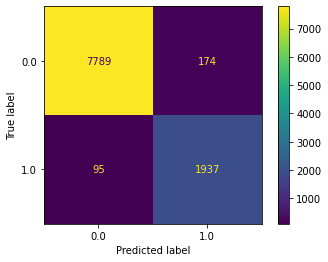

In [99]:
from sklearn.metrics import plot_confusion_matrix
cfm_raw = plot_confusion_matrix(model_dummy,X, y, values_format = '') # add normalize = 'true' for precision matrix or 'pred' for recall matrix
plt.savefig("cfm_raw.png")

In [100]:
from sklearn.metrics import classification_report

In [104]:
X_train, X_valid , y_train, y_valid = train_test_split( X, y, test_size=0.6, random_state=SEED,stratify=y)

In [108]:
model_dummy = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=SEED, max_features='sqrt', 
                                   max_depth=20,  min_samples_leaf=2,bootstrap=True, class_weight='balanced')
model_dummy.fit(X_train,y_train)

p = model_dummy.predict(X_valid)

In [109]:
target_names = ['class 0', 'class 1']
print(classification_report(p, y_valid, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.93      0.89      0.91      5012
     class 1       0.55      0.68      0.61       985

    accuracy                           0.86      5997
   macro avg       0.74      0.79      0.76      5997
weighted avg       0.87      0.86      0.86      5997



###  Precision-Recall 


Beispiel für eine Precision-Recall-Metrik zur Bewertung der Ausgabequalität des Klassifikators.

Precision-Recall ist ein nützliches Maß für den Erfolg der Vorhersage, wenn die Klassen sehr unausgewogen sind. Beim  der Precisiont ein Maß für die Relevanz der Ergebnisse, während die Recall ein Maß dafür ist, wie viele wirklich relevante Ergebnisse zurückgegeben werden.

Die Precision-Recall-Kurve zeigt den Kompromiss zwischen Precision und Recall für verschiedene Schwellenwerte. Ein hoher Bereich unter der Kurve stellt sowohl eine hohe Recall als auch eine hohe Präzision dar, wobei sich eine hohe Präzision auf eine niedrige Falsch-Positiv-Rate und eine hohe Recall auf eine niedrige Falsch-Negativ-Rate bezieht. Hohe Punktzahlen für beide zeigen, dass der Klassifikator genaue Ergebnisse (hohe Präzision) sowie die Mehrheit aller positiven Ergebnisse (hohe Erinnerung) zurückgibt.

Ein System mit hoher Recall, aber geringer Precision gibt viele Ergebnisse zurück, aber die meisten seiner vorhergesagten Bezeichnungen sind im Vergleich zu den Trainingsbezeichnungen falsch. Ein System mit hoher Präzision, aber geringem Recall ist genau das Gegenteil, es gibt nur sehr wenige Ergebnisse zurück, aber die meisten seiner vorhergesagten Bezeichnungen sind im Vergleich zu den Trainingsbezeichnungen korrekt. Ein ideales System mit hoher Präzision und hoher Recall liefert viele Ergebnisse, wobei alle Ergebnisse korrekt beschriftet sind.

PRC-Interpretation
1. Am niedrigsten Punkt, dh bei (0, 0) – wird die Schwelle auf 1,0 gesetzt. Das bedeutet, dass unser Modell keinen Unterschied zwischen Kunden, die Abwander werden oder nicht.
2. Am höchsten Punkt, dh bei (1, 1), wird die Schwelle auf 0,0 gesetzt. Das bedeutet, dass unsere Präzision und Erinnerung hoch sind und das Modell perfekt Unterscheidungen treffen kann.
3. Der Rest der Kurve sind die Werte von Precision und Recall für die Schwellenwerte zwischen 0 und 1. Unser Ziel ist es, die Kurve so nah wie möglich an (1, 1) zu bringen, was eine gute Precision und Recall bedeutet.
4. Ähnlich wie bei ROC ist die Fläche mit der Kurve und den Achsen als Grenzen die Fläche unter der Kurve (AUC). Betrachten Sie diesen Bereich als Maß für ein gutes Modell. Die AUC reicht von 0 bis 1. Daher sollten wir einen hohen AUC-Wert anstreben. 

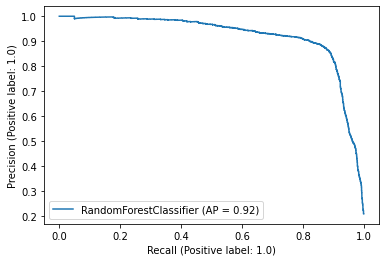

In [289]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model_dummy, X, y, name="RandomForestClassifier" )

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile
from sklearn.metrics import mean_absolute_error


### Features Selection

Es gibt drei Methoden um eine Feature Selection durchzuführen

**1.Filter Methods**

**2. Wrapper Methods**

**3. Embedded Methods**


Die wichtigsten Gründe für die Verwendung der Features Selection sind:

- Es ermöglicht dem maschinellen Lernalgorithmus, schneller zu trainieren.
- Es reduziert die Komplexität eines Modells und erleichtert dessen Interpretation.
- Es verbessert die Genauigkeit eines Modells, wenn die richtige Teilmenge ausgewählt wird.
- Es reduziert die Überanpassung.

1. Filtermethoden werden im Allgemeinen als Vorverarbeitungsschritt verwendet. Die Auswahl der Features ist unabhängig vom Modell. Stattdessen werden Merkmale auf der Grundlage ihrer Ergebnisse in verschiedenen statistischen Tests für ihre Korrelation mit der Ergebnisvariablen ausgewählt. Die Korrelation ist hier ein subjektiver Begriff. Als grundlegende Anleitung können Sie sich auf die folgende Tabelle zum Definieren von Korrelationskoeffizienten beziehen.

![Haöllpo](bild/FS1.png)


2. Bei Wrapper-Methoden versuche ich, eine Teilmenge von Funktionen zu verwenden und ein Modell damit zu trainieren. Basierend auf den Schlussfolgerungen, die wir aus dem vorherigen Modell ziehen, entscheide ich, Features zu ihrer Teilmenge hinzuzufügen oder daraus zu entfernen. Das Problem wird im Wesentlichen auf ein Suchproblem reduziert. Diese Verfahren sind in der Regel sehr rechenintensiv. Einige gängige Beispiele für Wrapper-Methoden sind Vorwärts-Feature-Auswahl, Rückwärts-Feature-Eliminierung und Rekursive-Feature-Eliminierung .


3. Eingebettete Methoden kombinieren die Qualitäten von Filter- und Wrapper-Methoden. Es wird von Algorithmen implementiert, die über eigene integrierte Methoden zur Merkmalsauswahl verfügen. Einige der beliebtesten Beispiele für diese Methoden sind die LASSO- und RIDGE-Regression, die über eingebaute Bestrafungsfunktionen verfügen, um eine Überanpassung zu reduzieren. Die Lasso-Regression führt eine L1-Regularisierung durch, die eine Strafe hinzufügt, die dem absoluten Wert der Größe der Koeffizienten entspricht. Die Ridge-Regression führt eine L2-Regularisierung durch, die eine Strafe hinzufügt, die dem Quadrat der Größe der Koeffizienten entspricht.

**Unterschied zwischen Filter- und Wrapper-Methoden**

1. Filtermethoden messen die Relevanz von Merkmalen anhand ihrer Korrelation mit abhängigen Variablen, während Wrapper-Methoden die Nützlichkeit einer Teilmenge von Merkmalen messen, indem sie tatsächlich ein Modell darauf trainieren.
2. Filtermethoden sind im Vergleich zu Wrapper-Methoden viel schneller, da sie kein Training der Modelle beinhalten. Andererseits sind Wrapper-Methoden auch sehr rechenintensiv.
3. Filtermethoden verwenden statistische Methoden zur Bewertung einer Teilmenge von Merkmalen, während Wrapper-Methoden eine Kreuzvalidierung verwenden.
4. Filtermethoden können in vielen Fällen nicht die beste Teilmenge von Merkmalen finden, aber Wrapper-Methoden können immer die beste Teilmenge von Merkmalen bereitstellen.
5. Die Verwendung der Teilmenge von Merkmalen aus den Wrapper-Methoden macht das Modell anfälliger für eine Überanpassung im Vergleich zur Verwendung einer Teilmenge von Merkmalen aus den Filtermethoden.

**In diesem Fall habe ich die Filter-Methode verwendet.**

Mit der Methode SelectKBest wird p-Wert mit den Parameter f_classif berechnet. Der p-Wert gibt an, wie das Signifikanzniveau von jeden Features unter sich und ihrer Beziehung zum Target ausfällt. K ist die Zahl von Features.
Nacher wird es berechnet, welche Merkmalen (Features) nach Wichtigkeitsgewichten ausgewählt werden.


In [41]:
X_train, X_valid , y_train, y_valid = train_test_split( X, y, test_size=0.5, random_state=SEED)

In [42]:
k_vs_score = []

for k in range(1,14):
    
    selector = SelectKBest(score_func= f_classif, k=k)
    X_train2 = selector.fit_transform(X_train,y_train)
    Xval2 = selector.transform(X_valid)

    mdl = model_dummy
    mdl.fit(X_train2, y_train)

    p = mdl.predict(Xval2)

    score = mean_absolute_error(y_valid, p)

    print('k = {} -MAE = {}'.format(k,score)) 
    
    k_vs_score.append(score)
 
    


k = 1 -MAE = 0.2676338169084542
k = 2 -MAE = 0.2688010672002668
k = 3 -MAE = 0.255794563948641
k = 4 -MAE = 0.20543605135901283
k = 5 -MAE = 0.21527430381857596
k = 6 -MAE = 0.21577455394363848
k = 7 -MAE = 0.21860930465232617
k = 8 -MAE = 0.2194430548607637
k = 9 -MAE = 0.1617475404368851
k = 10 -MAE = 0.15557778889444723
k = 11 -MAE = 0.14307153576788395
k = 12 -MAE = 0.14207103551775888
k = 13 -MAE = 0.14107053526763383


- Die X Achse sind die mean_absolute_error
- Die Y Achse sind die Anzahl von Parameter


Die beste Zahl ist, wo die Kurve ohne Maximuns oder Miminun Punkten stabil ist . In diesem Fall ab 11. Parameter.




<AxesSubplot:>

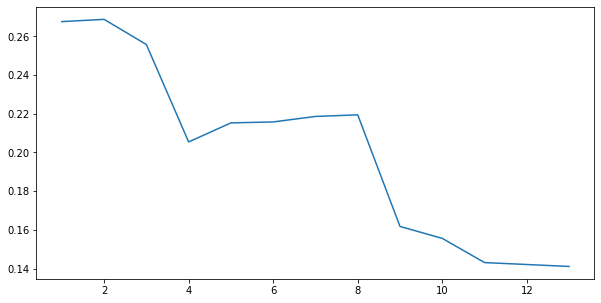

In [363]:
pd.Series(k_vs_score, index=range(1,14)).plot(figsize = (10,5))

**Welche Spalten sind die Wichtigen ?**

In [47]:
selector = SelectKBest(score_func= f_classif, k=12)
selector.fit(X_train,y_train)
mask = selector.get_support()
X_valid.columns[mask]

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'EstimatedSalary', 'Female', 'Male', 'France',
       'Spain', 'Germany'],
      dtype='object')

<AxesSubplot:>

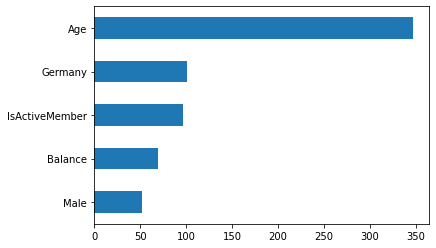

In [51]:
pd.Series(selector.scores_, index=X_train.columns).sort_values( ascending=True).tail(5).plot.barh()

### Nächste Schritte:

- **Voting-Ensemble-Klassifikator**: Beim Ensemble-Schätzer geht es darum, daß mehrere Modelle trainiert und dann die Ergebnisse für eine robustere Vorhersage aggregiert werden.


- **Error Analysis**: Bei der Error Analysis vergleicht man die Prediction und die Wahrenwert. Die Spalten, die das Modell fehlerhaft war, werden dann isoliert. Mit diesen beiden Spalten werden nach Muster auf die Features untersucht, um herauszufinden, wo (Welche Features) das Modell fehlerhaft ist.


- **Gruppierung von Features ausprobieren**: Hier kann Kombinationen von Features in das Modell ausprobiert werden, um ein besseres Scoring zu bekommen.


- **Gradient Boosting**: Gradient Boosting ist Aufgrund seiner Lernmethode für die Modellierung unausgeglichener Datensätzen gut geeignet. Der Prozess läuft hier sequentiell ab. Jedes Mal, wenn eine falsche Vorhersage gemacht wurde, wird der Fokus auf die falsche vorhergesagte Beobachtung gelegt.


- **Resampling durch Over- oder Undersampling**: Die Anzahl der Instanzen jeder Klasse so anzupassen, dass sie ausgeglichen sind. Beim Undersampling werden Instanzen der überrepräsentierten Klasse entfernt. Beim Oversampling werden synthetische Instanzen dem Trainingsdatensatz hinzugefügt.
